In [1]:
%matplotlib inline
from PIL import Image
import numpy
import os
import re
import random
from resizeimage import resizeimage
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.decomposition import PCA
import copy
import matplotlib.image as mpimg
from sklearn.decomposition import RandomizedPCA

In [2]:
import collections
# resize images
def resizeImagesToDest(source, dest, prefix, height, noiseAlgo=None):    
    for root, dirs, files in os.walk(source):
        for name in files:
            if re.match(r'^'+prefix+'.*gif$', name, re.I):
                img = Image.open(os.path.join(source, name))
                (origWidth, origHeight) = img.size
                if (height == origHeight):
                    resizedImg = img
                else:
                    resizedImg = resizeimage.resize_height(img, height)
                
                (width, height) = resizedImg.size
                if noiseAlgo:
                    noisyImg = noiseAlgo(numpy.asarray(resizedImg))
                    Image.fromarray(numpy.uint8(noisyImg.reshape(height,width))).save(dest+name)
                else:
                    resizedImg.save(dest+name)

def resizeImages(source, prefix):
    resizeImagesToDest(source, 'yalefaces_resized/', prefix, 50)
                
# images into array: http://stackoverflow.com/questions/13550376/pil-image-to-array-numpy-array-to-array-python
def readImagesIntoMatrix(path, prefix):
    images = None
    groups = collections.defaultdict(set)
    grouptag = {}
    i = 0
    for root, dirs, files in os.walk(path):
        for name in files:
            if re.match(r'^'+prefix+'.*gif$', name, re.I):
                img = Image.open(path + name)                
                (width, height) = img.size
                imgArr = numpy.asarray(img).reshape(height * width)
                if images is not None:
                    images = numpy.vstack([images, imgArr])
                else:
                    images = imgArr
                group = re.match(r'.*yaleB([0-9]+)_.*', name, re.I).group(1)
                groups[group].add(i)
                grouptag[i] = group
                i += 1
    return images, groups, grouptag

def saveImages(path, images, width, height):
    for i in range(0, len(images)):
        Image.fromarray(numpy.uint8(images[i]).reshape(height, width)).save(path+str(i)+'.gif')
        
def addGaussianNoise(image):
    noisyImage = copy.deepcopy(image)
    mu = noisyImage.mean()
    std = noisyImage.std()
    noise = 0.2 * numpy.random.normal(mu, std, noisyImage.shape)
    for i in range(len(image)):
        for j in range(len(image[0])):
            val = image[i][j]
            if val + noise[i][j] >= 255:
                noisyImage[i][j] = 255
            elif val + noise[i][j] <= 0:
                noisyImage[i][j] = 0
            else:
                noisyImage[i][j] = val + noise[i][j] 
    
    return noisyImage  
    
def addSparseNoise(image):
    noisyImage = copy.deepcopy(image)
    for i in range(len(image)):
        for j in range(len(image[0])):
            rand = random.random()
            if (rand <= 0.01):
                noisyImage[i][j] = 0
    
    return noisyImage

In [3]:
imageList, groups, grouptag = readImagesIntoMatrix('bestyalefaces/', '.*')
imageList = imageList.T

print("Images %s" % imageList)

(width, height) = 168, 192
Image.fromarray(numpy.uint8(imageList.T[0].reshape(height,width))).save("secondyaletest/testsaveimage1.gif")
Image.fromarray(numpy.uint8(imageList.T[100].reshape(height,width))).save("secondyaletest/testsaveimage100.gif")

Images [[ 72  55  53 ...,  90 127  39]
 [ 73  59  55 ...,  86 130  38]
 [ 75  65  55 ...,  86 132  41]
 ..., 
 [ 34  60  88 ...,  88  15  46]
 [ 33  55  57 ...,  85  15  39]
 [ 31  48  36 ...,  82  17  32]]


In [4]:
# average Image
#print('Num images %s' % (imageList.shape,))
avgImg = imageList.mean(axis=1)
print('Average image %s' % (avgImg))
normalizedImageList = imageList - avgImg.reshape(width*height,1)*numpy.ones((1,len(imageList.T)))
Image.fromarray(numpy.uint8(avgImg.reshape(height,width))).save('secondyaletest/avgImg.gif')

Average image [ 58.31160896  60.38492872  62.75763747 ...,  46.24236253  44.76985743
  43.42158859]


In [5]:
def normalize_face(vector):
    minValue = numpy.amin(vector)
    maxValue = numpy.amax(vector)
    scale = (255./(maxValue-minValue))
    return (vector - minValue)*scale

# Fit with PCA for 90% of variance
pca = PCA(0.9).fit_transform(normalizedImageList)
print('With PCA there were %s eigenfaces that captures 90pct of the variance' % len(pca.T))

for i in range(len(pca.T)):
    eigv = pca[:,i].reshape(1,width * height).T
    eigenface = normalize_face(eigv)
    Image.fromarray(numpy.uint8(eigenface.reshape(height,width))).save('secondyaletest/trial3-eigenface%s.gif' % i)

With PCA there were 41 eigenfaces that captures 90pct of the variance


In [6]:
from numpy.linalg import norm, svd
from scipy.io import loadmat, savemat

def inexact_augmented_lagrange_multiplier(X, lmbda=.01, tol=1e-3,
                                          maxiter=100, verbose=True):
    """
    Inexact Augmented Lagrange Multiplier
    """
    Y = X
    norm_two = norm(Y.ravel(), 2)
    norm_inf = norm(Y.ravel(), numpy.inf) / lmbda
    dual_norm = numpy.max([norm_two, norm_inf])
    Y = Y / dual_norm
    A = numpy.zeros(Y.shape)
    E = numpy.zeros(Y.shape)
    dnorm = norm(X, 'fro')
    mu = 1.25 / norm_two
    rho = 1.5
    sv = 10.
    n = Y.shape[0]
    itr = 0
    while True:
        if verbose:
            print('Iterations %s' % itr)
        Eraw = X - A + (1 / mu) * Y
        Eupdate = numpy.maximum(Eraw - lmbda / mu, 0) + numpy.minimum(Eraw + lmbda / mu, 0)
        U, S, V = svd(X - Eupdate + (1 / mu) * Y, full_matrices=False)
        svp = (S > 1 / mu).shape[0]
        if svp < sv:
            sv = numpy.min([svp + 1, n])
        else:
            sv = numpy.min([svp + round(.05 * n), n])
        Aupdate = numpy.dot(numpy.dot(U[:, :svp], numpy.diag(S[:svp] - 1 / mu)), V[:svp, :])
        A = Aupdate
        E = Eupdate
        Z = X - A - E
        Y = Y + mu * Z
        mu = numpy.min([mu * rho, mu * 1e7])
        itr += 1
        if ((norm(Z, 'fro') / dnorm) < tol) or (itr >= maxiter):
            break
    if verbose:
        print("Finished at iteration %d" % (itr))  
    return A,E

In [7]:
A, E = inexact_augmented_lagrange_multiplier(normalizedImageList, lmbda=0.01)

Iterations 0
Iterations 1
Iterations 2
Iterations 3
Iterations 4
Iterations 5
Iterations 6
Iterations 7
Iterations 8
Iterations 9
Iterations 10
Iterations 11
Iterations 12
Iterations 13
Iterations 14
Iterations 15
Iterations 16
Iterations 17
Finished at iteration 18


In [8]:
A2, E2 = inexact_augmented_lagrange_multiplier(normalizedImageList, lmbda=0.005)

Iterations 0
Iterations 1
Iterations 2
Iterations 3
Iterations 4
Iterations 5
Iterations 6
Iterations 7
Iterations 8
Iterations 9
Iterations 10
Iterations 11
Iterations 12
Iterations 13
Iterations 14
Iterations 15
Iterations 16
Iterations 17
Iterations 18
Iterations 19
Iterations 20
Iterations 21
Iterations 22
Iterations 23
Iterations 24
Iterations 25
Finished at iteration 26


In [9]:
A3, E3 = inexact_augmented_lagrange_multiplier(normalizedImageList, lmbda=0.02)

Iterations 0
Iterations 1
Iterations 2
Iterations 3
Iterations 4
Iterations 5
Iterations 6
Iterations 7
Iterations 8
Iterations 9
Iterations 10
Iterations 11
Iterations 12
Iterations 13
Iterations 14
Iterations 15
Iterations 16
Finished at iteration 17


In [10]:
A4, E4 = inexact_augmented_lagrange_multiplier(normalizedImageList, lmbda=0.001)

Iterations 0
Iterations 1
Iterations 2
Iterations 3
Iterations 4
Iterations 5
Iterations 6
Iterations 7
Iterations 8
Iterations 9
Iterations 10
Iterations 11
Iterations 12
Iterations 13
Iterations 14
Iterations 15
Iterations 16
Iterations 17
Iterations 18
Iterations 19
Iterations 20
Iterations 21
Iterations 22
Iterations 23
Iterations 24
Iterations 25
Finished at iteration 26


In [11]:
Image.fromarray(numpy.uint8((A.T[0] + avgImg).reshape(height,width))).save("secondyaletest/testsaveimage1afterrpca.gif")

print('Error %s' % E)
print('Error %s' % E2)

print('Relative error %s %s' % (0.01, numpy.linalg.norm(E, 'fro')/numpy.linalg.norm(normalizedImageList, 'fro')))
print('Relative error %s %s' % (0.005, numpy.linalg.norm(E2, 'fro')/numpy.linalg.norm(normalizedImageList, 'fro')))
print('Relative error %s %s' % (0.2, numpy.linalg.norm(E3, 'fro')/numpy.linalg.norm(normalizedImageList, 'fro')))
print('Relative error %s %s' % (0.001, numpy.linalg.norm(E4, 'fro')/numpy.linalg.norm(normalizedImageList, 'fro')))

Error [[ 0.          0.          0.         ...,  0.          5.63172223  0.        ]
 [ 0.          0.          0.         ...,  0.          4.02074679  0.        ]
 [ 0.          0.          0.         ...,  0.          4.02461513  0.        ]
 ..., 
 [ 1.21960079  0.          0.         ...,  0.          0.41168425  0.        ]
 [ 0.71012998  0.          0.         ...,  0.          1.57855862  0.        ]
 [ 1.85933242  0.         -7.33847686 ...,  0.          1.87172113  0.        ]]
Error [[  6.66120928e+00  -1.24380137e+00   4.52611558e+00 ...,   1.02732823e+01
    2.34603114e+01  -9.81082549e-01]
 [  4.18583568e+00  -1.06432019e+00   4.21760569e+00 ...,   4.42893980e+00
    2.33528981e+01  -1.50027673e+00]
 [  3.86489025e+00  -1.74685687e-02   3.46913129e+00 ...,   5.71292100e+00
    2.03154553e+01  -3.72414433e-02]
 ..., 
 [  4.20623982e+00   3.11164048e+00  -2.60837552e+00 ...,   3.62843725e+00
    6.78597594e+00   6.07793287e+00]
 [  3.90610198e+00   4.70724647e+00  -2.62140

In [12]:

# Fit with PCA for 90% of variance
rpca = PCA(0.9).fit_transform(A)
rpca2 = PCA(0.9).fit_transform(A2)
rpca4 = PCA(0.9).fit_transform(A4)

print('After RPCA (lam=%s) there were %s eigenfaces that captures 90pct of the variance' % (0.01, len(rpca.T)))
print('After RPCA (lam=%s) there were %s eigenfaces that captures 90pct of the variance' % (0.005, len(rpca2.T)))
print('After RPCA (lam=%s) there were %s eigenfaces that captures 90pct of the variance' % (0.001, len(rpca4.T)))

#Let's make images for the same number of eigenfaces we used originally
rpca = PCA(len(pca.T)).fit_transform(A)
rpca2 = PCA(len(pca.T)).fit_transform(A2)
rpca3 = PCA(len(pca.T)).fit_transform(A3)
rpca4 = PCA(len(pca.T)).fit_transform(A4)

After RPCA (lam=0.01) there were 32 eigenfaces that captures 90pct of the variance
After RPCA (lam=0.005) there were 16 eigenfaces that captures 90pct of the variance
After RPCA (lam=0.001) there were 2 eigenfaces that captures 90pct of the variance


In the original dimension silhouette is 0.166405170822
Clustering silhouette over PCA [-0.30996192566169595, -0.27541908007819305, -0.2084603498609488, -0.13584306071446975, -0.085266977039701042, -0.039499189643622444, -0.013408245952882742, 0.015754100147169981, 0.043123757817553343, 0.059118872368010146, 0.077258317071495081, 0.092138058883191043, 0.10127814816675916, 0.1128741328365202, 0.1244387102488418, 0.13134587769217609, 0.13712406724993192, 0.14399989660019855, 0.15026835100307967, 0.15696182769344608, 0.16214279501784537, 0.16680572822778289, 0.17128856084005481, 0.17427443591768388, 0.17686739474600727, 0.17887094836197068, 0.18142416375176418, 0.18456405512049959, 0.18745787316164625, 0.19087561583285517, 0.19482045674580423, 0.19729524746378113, 0.19880802838649891, 0.20063688391231382, 0.20314639213122357, 0.20540721688480643, 0.20643860010593409, 0.20731062738578965, 0.20898001826908075, 0.21009583812399713, 0.21290051950591735]


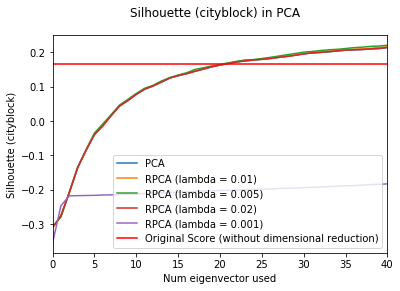

In the original dimension silhouette is 0.303279512156
Clustering silhouette over PCA [-0.30996192566169595, -0.27541908007819305, -0.2084603498609488, -0.13584306071446975, -0.085266977039701042, -0.039499189643622444, -0.013408245952882742, 0.015754100147169981, 0.043123757817553343, 0.059118872368010146, 0.077258317071495081, 0.092138058883191043, 0.10127814816675916, 0.1128741328365202, 0.1244387102488418, 0.13134587769217609, 0.13712406724993192, 0.14399989660019855, 0.15026835100307967, 0.15696182769344608, 0.16214279501784537, 0.16680572822778289, 0.17128856084005481, 0.17427443591768388, 0.17686739474600727, 0.17887094836197068, 0.18142416375176418, 0.18456405512049959, 0.18745787316164625, 0.19087561583285517, 0.19482045674580423, 0.19729524746378113, 0.19880802838649891, 0.20063688391231382, 0.20314639213122357, 0.20540721688480643, 0.20643860010593409, 0.20731062738578965, 0.20898001826908075, 0.21009583812399713, 0.21290051950591735]


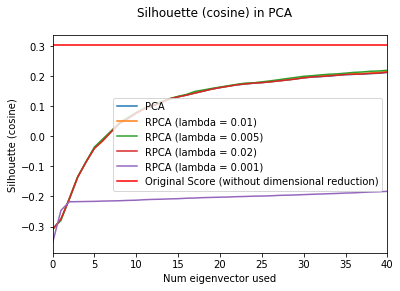

In the original dimension silhouette is 0.190953554789
Clustering silhouette over PCA [-0.30996192566169595, -0.27541908007819305, -0.2084603498609488, -0.13584306071446975, -0.085266977039701042, -0.039499189643622444, -0.013408245952882742, 0.015754100147169981, 0.043123757817553343, 0.059118872368010146, 0.077258317071495081, 0.092138058883191043, 0.10127814816675916, 0.1128741328365202, 0.1244387102488418, 0.13134587769217609, 0.13712406724993192, 0.14399989660019855, 0.15026835100307967, 0.15696182769344608, 0.16214279501784537, 0.16680572822778289, 0.17128856084005481, 0.17427443591768388, 0.17686739474600727, 0.17887094836197068, 0.18142416375176418, 0.18456405512049959, 0.18745787316164625, 0.19087561583285517, 0.19482045674580423, 0.19729524746378113, 0.19880802838649891, 0.20063688391231382, 0.20314639213122357, 0.20540721688480643, 0.20643860010593409, 0.20731062738578965, 0.20898001826908075, 0.21009583812399713, 0.21290051950591735]


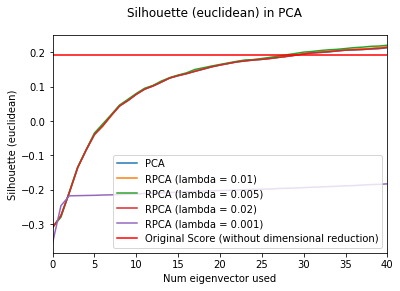

In [13]:
xdata = [0.0]*len(pca.T)
ydata = [0.0]*len(pca.T)
ydataRPCA = [0.0]*len(pca.T)
ydataRPCA2 = [0.0]*len(pca.T)
ydataRPCA3 = [0.0]*len(pca.T)
ydataRPCA4 = [0.0]*len(pca.T)

from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score

pca_normalized = normalize(pca, axis=0, norm='l2')
rpca_normalized = normalize(rpca, axis=0, norm='l2')
rpca2_normalized = normalize(rpca2, axis=0, norm='l2')
rpca3_normalized = normalize(rpca3, axis=0, norm='l2')
rpca4_normalized = normalize(rpca4, axis=0, norm='l2')

grouptagarray = [""]*len(grouptag)
for i in range(len(grouptag)):
    grouptagarray[i] = grouptag[i]

for metric in ['cityblock', 'cosine', 'euclidean']:
    original_clustering = silhouette_score(normalizedImageList.T, grouptagarray, metric=metric)
    print('In the original dimension silhouette is %s' % original_clustering)

    for i in range(len(pca.T)):
      xdata[i] = i
      projected = normalizedImageList.T.dot(pca_normalized[:,:i+1])
      ydata[i] = silhouette_score(projected, grouptagarray)
    
      # lambda = 0.01
      projectedRPCA = normalizedImageList.T.dot(rpca_normalized[:,:i+1])
      ydataRPCA[i] = silhouette_score(projectedRPCA, grouptagarray)
    
      # lambda = 0.005
      projectedRPCA2 = normalizedImageList.T.dot(rpca2_normalized[:,:i+1])
      ydataRPCA2[i] = silhouette_score(projectedRPCA2, grouptagarray)
    
      # lambda = 0.02
      projectedRPCA3 = normalizedImageList.T.dot(rpca3_normalized[:,:i+1])
      ydataRPCA3[i] = silhouette_score(projectedRPCA3, grouptagarray)
    
      # lambda = 0.001
      projectedRPCA4 = normalizedImageList.T.dot(rpca4_normalized[:,:i+1])
      ydataRPCA4[i] = silhouette_score(projectedRPCA4, grouptagarray)

    print('Clustering silhouette over PCA %s' % ydata)

    fig = plt.figure()
    fig.suptitle("Silhouette (%s) in PCA" % metric)
    plt.plot(xdata, ydata, label="PCA")
    plt.plot(xdata, ydataRPCA, label="RPCA (lambda = 0.01)")
    plt.plot(xdata, ydataRPCA2, label="RPCA (lambda = 0.005)")
    plt.plot(xdata, ydataRPCA3, label="RPCA (lambda = 0.02)")
    plt.plot(xdata, ydataRPCA4, label="RPCA (lambda = 0.001)")
    plt.axhline(y=original_clustering, color='r', linestyle='-', label='Original Score (without dimensional reduction)')
    plt.xlabel("Num eigenvector used")
    plt.ylabel("Silhouette (%s)" % metric)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.legend()
    plt.savefig("figures/rpcatrial3%s.png" % metric, format = 'png')
    plt.show()
    plt.close()


In [14]:
imagesH = None
rpcaImagesH = None
rpcaImagesH2 = None
rpcaImagesH3 = None

count = 0
for i in groups["24"]:
    if count > 5:
        break
    if imagesH is None:
        imagesH = imageList.T[i].reshape(height,width)
    else:
        imagesH = numpy.hstack([imagesH, imageList.T[i].reshape(height,width)])
    if rpcaImagesH is None:
        rpcaImagesH = (A.T[i] + avgImg).reshape(height,width)
    else:
        rpcaImagesH = numpy.hstack([rpcaImagesH, (A.T[i] + avgImg).reshape(height,width)])
    if rpcaImagesH2 is None:
        rpcaImagesH2 = (A2.T[i] + avgImg).reshape(height,width)
    else:
        rpcaImagesH2 = numpy.hstack([rpcaImagesH2, (A2.T[i] + avgImg).reshape(height,width)])
    if rpcaImagesH3 is None:
        rpcaImagesH3 = (A4.T[i] + avgImg).reshape(height,width)
    else:
        rpcaImagesH3 = numpy.hstack([rpcaImagesH3, (A4.T[i] + avgImg).reshape(height,width)])
    count += 1
    
def removeOutliers(array):
    for i in range(len(array)):
        for j in range(len(array[0])):
            if array[i][j] > 255:
                array[i][j] = 255
            elif array[i][j] < 0:
                array[i][j] = 0
    return array
    
Image.fromarray(numpy.uint8(imagesH)).save("figures/person24trial3.gif")
Image.fromarray(numpy.uint8(removeOutliers(rpcaImagesH))).save("figures/person24Afterl=0dot01RPCAtrial3.gif")
Image.fromarray(numpy.uint8(removeOutliers(rpcaImagesH2))).save("figures/person24Afterl=0dot005RPCAtrial3.gif")
Image.fromarray(numpy.uint8(removeOutliers(rpcaImagesH3))).save("figures/person24Afterl=0dot001RPCAtrial3.gif")

In [48]:
def AddH(images, toadd):
    if images is None:
        images = toadd
    else:
        images = numpy.hstack([images, toadd])
    return images
        
def AddV(images, toadd):
    if images is None:
        images = toadd
    else:
        images = numpy.vstack([images, toadd])
    return images
        
imagesV = None
rpcaImagesV = None
rpcaImagesV4 = None

height, width = 192, 168
    

for k in range(0, len(pca.T), 5):
    rowImagesH = None
    rowRpcaImagesH = None
    rowRpcaImagesH4 = None
    for j in range(0, 5):
        i = j + k
        print(i)
        if i < len(pca.T):
            eigv = pca[:,i].reshape(1,width * height).T
            eigenface = normalize_face(eigv).reshape(height, width)
            rpcaeigv = rpca2[:,i].reshape(1,width * height).T
            rpcaeigenface = normalize_face(rpcaeigv).reshape(height, width)
            rpcaeigv4 = rpca4[:,i].reshape(1,width * height).T
            rpcaeigenface4 = normalize_face(rpcaeigv4).reshape(height, width)
        else:
            eigenface = 255*numpy.ones((height, width))
            rpcaeigenface = 255*numpy.ones((height, width))
            rpcaeigenface4 = 255*numpy.ones((height, width))
        rowImagesH = AddH(rowImagesH, eigenface)
        rowRpcaImagesH = AddH(rowRpcaImagesH, rpcaeigenface)
        rowRpcaImagesH4 = AddH(rowRpcaImagesH4, rpcaeigenface4)
    imagesV = AddV(imagesV, rowImagesH)
    rpcaImagesV = AddV(rpcaImagesV, rowRpcaImagesH)
    rpcaImagesV4 = AddV(rpcaImagesV4, rowRpcaImagesH4)
        
Image.fromarray(numpy.uint8(imagesV)).save("figures/trial3eigenfaces.gif")
Image.fromarray(numpy.uint8(rpcaImagesV)).save("figures/trial3rpca0dot005eigenfaces.gif")
Image.fromarray(numpy.uint8(rpcaImagesV4)).save("figures/trial3rpca0dot001eigenfaces.gif")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
